# Flu Shot Learning - Driven Data
This notebook is an attempt to solve the problem described in the Driven Data Flu Shot Learning competition (https://www.drivendata.org/competitions/66/flu-shot-learning/).

Namely, given the results of a survey, can we predict whether an individual is vaccinated against the H1N1 flu strain and has received a seasonal flu vaccination.
The data are freely available at the Driven Data website

## Import relevant data, packages, etc

In [15]:
# packages, libraries, etc.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# data
path2files = 'C:/Users/kevjm/Documents/Python/DrivenData/FluShotLearning/data'
training_set_features = pd.read_csv(path2files + '/training_set_features.csv', index_col = 'respondent_id') 
training_set_labels = pd.read_csv(path2files + '/training_set_labels.csv', index_col = 'respondent_id') 
test_set_features = pd.read_csv(path2files + '/test_set_features.csv', index_col = 'respondent_id')

In [18]:
training_set_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


## Exploring the data
These cells will allow me to plot vaccine likelihood across a range of features to get a sense of what may or may not be related

In [20]:
# join training features and labels to enable easier plotting
joined_train_df = training_set_features.join(training_set_labels)
joined_train_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [81]:
# For a given feature, this prints out the number of people who are vaccinated based on a given answers response
feature_name = 'behavioral_antiviral_meds'
counts = (joined_train_df[[feature_name,'h1n1_vaccine','seasonal_vaccine']]
          .groupby([feature_name])
          .sum()
         )

# This cell will also print out the proportion of people vaccinated as a function of the total number of people who answered the same
tot_resp = joined_train_df[feature_name].value_counts()
props = counts.div(tot_resp,axis = 'index')
print('               %%%% Raw Counts: ' + feature_name + ' %%%%')
print(counts)
print('               %%%% Proportional Rates: ' + feature_name + ' %%%%')
print(props)

               %%%% Raw Counts: behavioral_antiviral_meds %%%%
                           h1n1_vaccine  seasonal_vaccine
behavioral_antiviral_meds                                
0.0                                5274             11764
1.0                                 371               623
               %%%% Proportional Rates: behavioral_antiviral_meds %%%%
                           h1n1_vaccine  seasonal_vaccine
behavioral_antiviral_meds                                
0.0                            0.208171          0.464338
1.0                            0.285165          0.478862


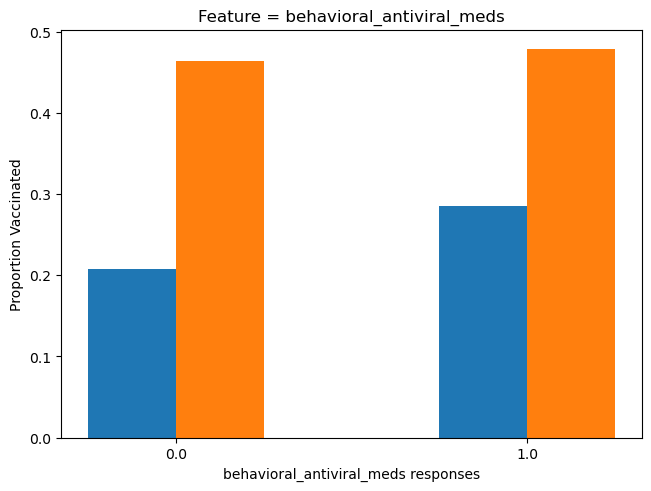

In [115]:
# With these data we can plot the likelihood of vaccination for each vaccine across response types
x = np.arange(len(props))
width = 0.25 #width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in props.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    # ax.bar_label(rects,padding = 3)
    multiplier += 1

plt.ylabel('Proportion Vaccinated')
plt.title(f'Feature = {feature_name}')
plt.xticks(x + width/2, props.index.to_list())
plt.xlabel(f'{feature_name} responses')
# plt.legend(loc = 'upper left')
plt.show()

In [131]:
# Define a function to plot the proportion bar plots for any feature name
def bar_plot_vacc_prop(feature_name):
    # find proportions
    counts = (joined_train_df[[feature_name,'h1n1_vaccine','seasonal_vaccine']]
              .groupby([feature_name])
              .sum()
             )
    tot_resp = joined_train_df[feature_name].value_counts()
    props = counts.div(tot_resp,axis = 'index')

    # plot output
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(props))
    width = .25
    multiplier = 0
    for attribute, measurement in props.items():
        offset = width*multiplier
        rects = ax.bar(x + offset, measurement, width, label = attribute)
        multiplier += 1
        
    ax.set_ylabel('Proportion Vaccinated')
    ax.set_title(f'Feature = {feature_name}')
    ax.set_xticks(x + width/2, props.index.to_list())
    ax.set_xlabel(f'{feature_name} responses')
    ax.set_ylim(0,1)
    ax.legend(loc = 'upper left')
    fig.canvas.draw()

In [132]:
joined_train_df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

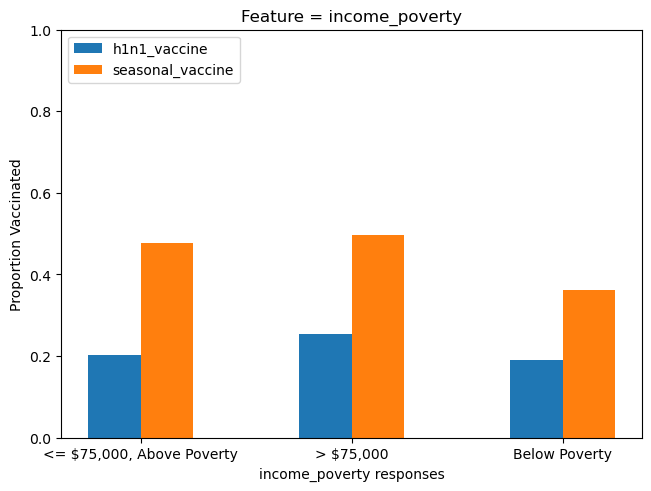

In [140]:
# insert variable of interest to inspect its effect on vaccination status
bar_plot_vacc_prop('income_poverty')

## Training a Model
I will train a Logistic Regression model to predict whether survey respondents are vaccinated. To prepare the data for a LR model, we'll need to take a few steps.

In [145]:
# Import relevant libraries and packages
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#set a random seed for reproducibility
random_seed = 42

### Pre-processing

First, some of these features are numerical (e.g., h1n1_concern) whereas others are categorical (e.g., age_group). I'd first like to create a list of column names for the numerical columns and categorical columns, respectively.

In [146]:
numeric_cols = (training_set_features
                .columns[training_set_features.dtypes != 'object']
                .values)
categorical_cols = (training_set_features
                .columns[training_set_features.dtypes == 'object']
                .values)
print(numeric_cols)
print(categorical_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']
['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa'
 'employment_industry' 'employment_occupation']


In [210]:
# for numerical columns, we will want to first impute the missing values and then scale these values
numeric_pline = Pipeline([
    ('scaler',StandardScaler()),
    ('imputer',SimpleImputer(strategy = 'median')) #here, I am using the median instead of mean as output values are integers
])

#for categorical columns, we will want to first impute the missing values and then encode these values to be useable by linear regression
categorical_pline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder())
])

#now we can combine our two pipelines into a ColumnTransformer to act on the training data
preprocess_full = ColumnTransformer([
    ('numeric_pipeline',numeric_pline,numeric_cols),
    ('categorical_pipeline',categorical_pline,categorical_cols)
])    

## Estimators

For this instance, we'll use a logistic regression model with ridge regularization to avoid overfitting. Because we are tasked with predicting the vaccination status of the H1N1 vaccine and the seasonal vaccine, independently, we'll use a MultiOutputClassifier. In addition, to find the most appropriate value for our regularization, we'll build a GridSearchCV into the LogisticRegression model.

In [226]:
param_grid = {'C': [.001, .005, .01, .05, .1, .5, 1]}
lr_gs = GridSearchCV(
    LogisticRegression(penalty = 'l2'),
    param_grid,cv=3,verbose=1)
est = MultiOutputClassifier(lr_gs)

## Combining into a single pipeline

Now, we should be able to put the pre-processing steps and estimators into a singular pipeline

In [227]:
full_pipeline = Pipeline([
    ('preprocessor',preprocess_full),
    ('estimator',est)
])

In [228]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavio...
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimator',
                 MultiOutputClassifier(estimator=GridSearchCV(cv=3,
                                                              estimator=LogisticRegression(),
                                                              param_grid={'C': [0.001,
                                                                                0.005,
                                                                                0.01,
                                                                                0.05,
                                                                                0.1,
                                                                                0.5,
                                                                                1]},
                                                              verbose=1)))])

## Training and Evaluation of Models

To evaluate our model prior to training on the full dataset, we'll first split the training data using an 80/20 split.

Due to the imbalance of the h1n1_vaccine classes, we could have erroneous classification. To mitigate that, we'll build in a stratify arguments to enforce even splits.

In [229]:
X_train, X_eval, y_train, y_eval = train_test_split(
    training_set_features,
    training_set_labels,
    test_size = 0.2,
    shuffle = True,
    stratify = training_set_labels,
    random_state=random_seed
)

Now we should be able to train the model:

In [230]:
#train the model on the split data
full_pipeline.fit(X_train,y_train)

# make predictions on the held-out data
preds = full_pipeline.predict(X_eval)
preds_probs = full_pipeline.predict_proba(X_eval)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [231]:
# we can take the probabilities output and create a new dataframe to match up predicted likelihood with actual vaccine status
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine_prob': preds_probs[0][:,1],
        'seasonal_vaccine_prob': preds_probs[1][:,1]
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine_prob,seasonal_vaccine_prob
respondent_id,,
22317,0.031511,0.529153
1215,0.686169,0.828739
10540,0.035280,0.085319
7407,0.095689,0.128366
14697,0.111092,0.273892


In [232]:
# With these data, we can now plot the ROC curve for all of the probabilities for each vaccine:
# first define a function to plot an roc_curve:
def plot_roc(y_true,y_predicted,label_name,ax=0):
    fpr, tpr, thr = roc_curve(y_true, y_predicted)
    roc_score = roc_auc_score(y_true,y_predicted)
    ax.plot(fpr,tpr,'k')
    ax.plot([0,1],[0,1],'r--')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'{label_name}: AUC = {roc_score:.2f}')

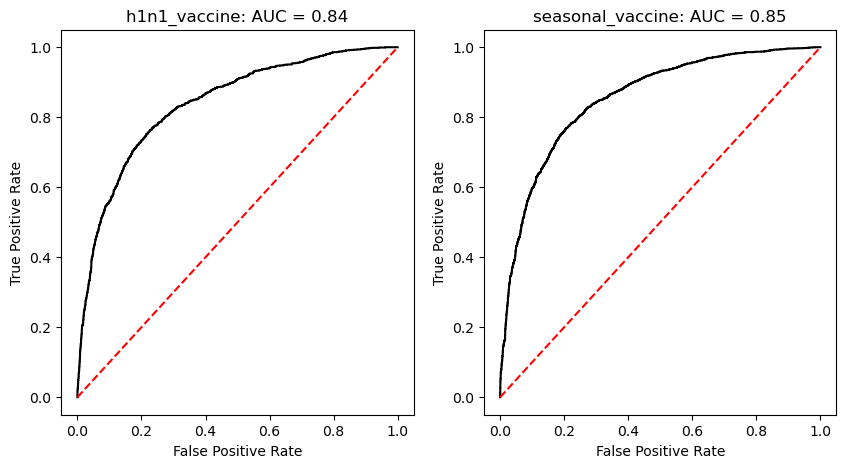

In [233]:
# plot ROC curves for each vaccine
fig,ax = plt.subplots(1,2,figsize=(10,5))
plot_roc(y_eval['h1n1_vaccine'],y_preds['h1n1_vaccine_prob'],'h1n1_vaccine',ax=ax[0])
plot_roc(y_eval['seasonal_vaccine'],y_preds['seasonal_vaccine_prob'],'seasonal_vaccine',ax=ax[1])

Our model produces an ROC score of 0.84 and 0.85 for the two vaccines. A score of 0.5 would be expected by random guessing, so this model is not too bad. In the future, I could potentially increase the performance of the model at different steps (see Results section below). However, for now, let's take our good-enough model and train it on the full dataset and predict the vaccine status for the survey respondents where the vaccine status is not known.

### Generate Predictions for the Test Set of Survey Responses

In [235]:
# First, we'll re-train the model but using the full training dataset
full_pipeline.fit(training_set_features,training_set_labels);

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [236]:
#Next, we'll use this version of the model to predict the probability of vaccination with the new data
test_probas = full_pipeline.predict_proba(test_set_features)

In [237]:
#Now, we can format the model's output into a submittable dataframe:
submission_df = pd.read_csv(path2files + '/submission_format.csv', index_col = 'respondent_id')

In [241]:
# note that this dataframe has dummy values of 0.5 and 0.7 which should be replaced with our predicted values
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [243]:
#Let's replace those values with the values our model predicted 
# (note that the order of respondent_id must be equal in the two dataframes for this code to work properly)
submission_df['h1n1_vaccine'] = test_probas[0][:,1]
submission_df['seasonal_vaccine'] = test_probas[1][:,1]
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.059350,0.289590
26708,0.046674,0.045937
26709,0.430629,0.592776
26710,0.498527,0.879780
26711,0.164594,0.472307


In [245]:
#Finally, let's save our results and submit to the competition webpage to get a result!
fname = 'FluShotLearning_Submission_MonkKevin_250715.csv'
submission_df.to_csv(fname,index = True)

### Results
With this model, the result was a score of 0.8348. At the time of this writing, this score is ranked as #1,353 of a total of 7,504 entries and the best reported score is 0.8658. Not bad but could be better!

In the future, I'd like to optimize this model and have a few ideas of where to start:
1. During preprocessing, I imputed values as the median and most-frequent for numerical and categorical values, respectively. A different imputation method (e.g., kNN imputation) could provide more accurate training data.
2. LogisticRegression is a very standard classification model, but there may be others that are more suited to these data.